In [17]:
from pathlib import Path
import os, json

CONFIG = "dataset_config.json"

def save_config(root):
    with open(CONFIG, "w") as f:
        json.dump({"dataset_root": str(root)}, f)

def repo_root():
    cwd = Path.cwd().resolve()
    if (cwd / "data").exists():
        return cwd
    if cwd.name == "main_code" and (cwd.parent / "data").exists():
        return cwd.parent.resolve()
    return cwd

def find_jpeg_dir(root):
    root = Path(root)
    for r, dirs, _ in os.walk(root):
        if "JPEGImages" in dirs:
            return Path(r) / "JPEGImages"
    return None

def ensure_dataset():
    base = repo_root() / "data" / "processed"
    candidates = [
        base / "PASCAL_VOC" / "PASCAL_VOC",
        base / "PASCAL_VOC",
        base
    ]
    json_names = {"pascal_train2007.json", "pascal_val2007.json", "pascal_test2007.json"}
    for target in candidates:
        if target.is_dir():
            json_ok = all((target / j).exists() for j in json_names)
            if json_ok or find_jpeg_dir(target):
                save_config(target)
                print("Using dataset under:", target)
                return target
    raise RuntimeError("Dataset not found. Expected under one of: " + ", ".join(str(c) for c in candidates))

dataset_root = Path(ensure_dataset())

Using dataset under: C:\Users\giaco\Desktop\Projects\PASCAL_VOC_2007\data\processed\PASCAL_VOC\PASCAL_VOC


In [46]:
# Relative paths: we use JSONs in data/processed/PASCAL_VOC/PASCAL_VOC (train/val/test)
import os
import json
from pathlib import Path

json_dir = dataset_root
json_dir_str = str(json_dir)
processed_root = json_dir.parent.parent  # go up to data/processed to find VOCtrainval/VOCtest
train_json = json_dir / "pascal_train2007.json"
val_json = json_dir / "pascal_val2007.json"
test_json = json_dir / "pascal_test2007.json"

trainval_jpeg_dir = processed_root / "VOCtrainval_06-Nov-2007" / "VOCdevkit" / "VOC2007" / "JPEGImages"
test_jpeg_dir = processed_root / "VOCtest_06-Nov-2007" / "VOCdevkit" / "VOC2007" / "JPEGImages"

with open(train_json, "r") as f:
    train_data = json.load(f)
with open(val_json, "r") as f:
    val_data = json.load(f)
with open(test_json, "r") as f:
    eval_data = json.load(f)

def candidate_image_paths(fname):
    # use declared paths directly, without recursive search
    return [
        trainval_jpeg_dir / fname,
        test_jpeg_dir / fname,
    ]

# Inspect content
print("Keys in the JSON file:", train_data.keys())
# keys are: images, type, annotations, categories

# Inspect first 5 images
print("First 5 images:", train_data['images'][:5])
# Inspect first 5 annotations
print("First 5 annotations:", train_data['annotations'][:5])
# Inspect categories
print("Categories:", train_data['categories'])
# Inspect dataset type
print("Type of dataset:", train_data['type'])

# Visualize 3 images
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def visualize_image(image_id):
    image_info = next(img for img in train_data['images'] if img['id'] == image_id)
    fname = image_info['file_name']

    image_path = None
    for c in candidate_image_paths(fname):
        if os.path.exists(c):
            image_path = c
            break

    if image_path is None:
        raise FileNotFoundError(
            f"Image {fname} not found. Tried paths: {[str(p) for p in candidate_image_paths(fname)]}")

    image = plt.imread(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    annotations = [ann for ann in train_data['annotations'] if ann['image_id'] == image_id]
    for ann in annotations:
        bbox = ann['bbox']
        category_name = next(cat['name'] for cat in train_data['categories'] if cat['id'] == ann['category_id'])
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1] - 10, category_name, color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

Keys in the JSON file: dict_keys(['images', 'type', 'annotations', 'categories'])
First 5 images: [{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}, {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17}, {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23}, {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26}, {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]
First 5 annotations: [{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'area': 34104, 'iscrowd': 0, 'image_id': 12, 'bbox': [155, 96, 196, 174], 'category_id': 7, 'id': 1, 'ignore': 0}, {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]], 'area': 13110, 'iscrowd': 0, 'image_id': 17, 'bbox': [184, 61, 95, 138], 'category_id': 15, 'id': 2, 'ignore': 0}, {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]], 'area': 81326, 'iscrowd': 0, 'image_id': 17, 'bbox': [89, 77, 314, 259], 'category_id': 13, 'id': 3, 'ignore': 0}, {'segmentation': [[

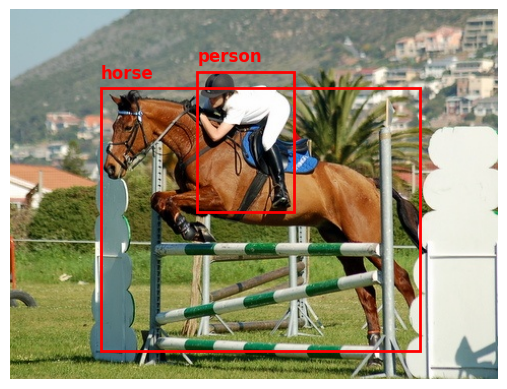

In [19]:
visualize_image(17)

In [ ]:
# so now we have a dataset and we want to create a CNN to train on it and recognize objects in images

import torch
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            # (3, 32) means: 3 input channels (RGB), 32 output filters (feature maps).
            # The filter is 3x3 because kernel_size=3.
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 112x112
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 56x56
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 28x28
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier
        # Input features: 128 (from last conv block)
        self.classifier = nn.Sequential(
            nn.Linear(128, 512),
            nn.LeakyReLU(0.1),
            # NOTE: We do not put Sigmoid here because we use BCEWithLogitsLoss
            # which includes sigmoid internally for numerical stability.
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

num_classes = len(train_data['categories'])
model = CNN(num_classes)
# Change: Use BCEWithLogitsLoss for multi-label classification (multi-object)
# This loss expects unnormalized LOGITS, not probabilities.
criterion = nn.BCEWithLogitsLoss()
# Slightly increase learning rate or keep standard, but add weight decay
optimizer = optim.Adam(model.parameters(), lr=0.0025, weight_decay=1e-4)

# now we need to train it on the dataset
# but first we need to create a DataLoader for the dataset
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class PascalVOCDataset(Dataset):
    def __init__(self, data, root, transform=None, num_classes=20):
        self.data = data
        self.root = root
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data['images'])

    def __getitem__(self, idx):
        image_info = self.data['images'][idx]
        fname = image_info['file_name']

        image_path = None
        for c in candidate_image_paths(fname):
            if os.path.exists(c):
                image_path = c
                break

        if image_path is None:
            raise FileNotFoundError(
                f"Image {fname} not found. Tried paths: {[str(p) for p in candidate_image_paths(fname)]}")

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Change: The target becomes a presence vector (multi-hot encoding)
        label = torch.zeros(self.num_classes, dtype=torch.float32)
        annotations = [ann for ann in self.data['annotations'] if ann['image_id'] == image_info['id']]
        
        for ann in annotations:
            # Assuming category_id starts from 1
            cat_idx = ann['category_id'] - 1
            if 0 <= cat_idx < self.num_classes:
                label[cat_idx] = 1.0

        return image, label

from torchvision import transforms

# We add Data Augmentation to make the model more robust
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard ImageNet Normalization
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = PascalVOCDataset(train_data, dataset_root, transform=transform_train, num_classes=num_classes)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Prepare Validation DataLoader
# Load validation dataset here to use it during training
val_dataset = PascalVOCDataset(val_data, dataset_root, transform=transform_val, num_classes=num_classes)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [21]:
import torch
print("torch version:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("device name:", torch.cuda.get_device_name(0))
    print("device count:", torch.cuda.device_count())

torch version: 2.6.0+cu124
torch.version.cuda: 12.4
cuda available: True
device name: NVIDIA GeForce RTX 3060 Laptop GPU
device count: 1


In [22]:
# training loop
from tqdm.notebook import tqdm
import torch # Ensure torch is imported if needed, though usually available
import numpy as np

num_epochs = 15
# Lists to save history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [], # (TP + TN) / Total
    'val_precision': [], # TP / (TP + FP)
    'val_recall': [], # TP / (TP + FN)
    'val_f1': [] # 2 * (P * R) / (P + R)
}

# Optional: Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")

model.to(device)

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    total_batches = len(dataloader)
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels) # BCEWithLogitsLoss
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_train_loss = running_loss / total_batches
    history['train_loss'].append(avg_train_loss)
    
    # --- Validation Phase ---
    model.eval()
    val_running_loss = 0.0
    val_tp, val_tn, val_fp, val_fn = 0, 0, 0, 0
    total_val_batches = len(val_dataloader)
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            
            # Metric calculation
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()
            
            # Element-wise stats
            val_tp += (predicted * labels).sum().item()
            val_tn += ((1 - predicted) * (1 - labels)).sum().item()
            val_fp += (predicted * (1 - labels)).sum().item()
            val_fn += ((1 - predicted) * labels).sum().item()
            
    avg_val_loss = val_running_loss / total_val_batches
    history['val_loss'].append(avg_val_loss)
    
    # Calculate aggregate metrics
    epsilon = 1e-7
    accuracy = (val_tp + val_tn) / (val_tp + val_tn + val_fp + val_fn + epsilon)
    precision = val_tp / (val_tp + val_fp + epsilon)
    recall = val_tp / (val_tp + val_fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    
    history['val_accuracy'].append(accuracy)
    history['val_precision'].append(precision)
    history['val_recall'].append(recall)
    history['val_f1'].append(f1)
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {accuracy:.4f} | "
          f"Val F1: {f1:.4f} | "
          f"LR: {current_lr:.6f}")

# save the trained model
torch.save(model.state_dict(), "cnn_pascalvoc.pth")
torch.save(history, "training_history.pth")

Training on device: cuda
Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


Epoch 1/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.2731 | Val Loss: 0.2450 | Val Acc: 0.9224 | Val F1: 0.0005 | LR: 0.002500


Epoch 2/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/15 | Train Loss: 0.2370 | Val Loss: 0.2321 | Val Acc: 0.9220 | Val F1: 0.1683 | LR: 0.002500


Epoch 3/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/15 | Train Loss: 0.2337 | Val Loss: 0.2411 | Val Acc: 0.9231 | Val F1: 0.1019 | LR: 0.002500


Epoch 4/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/15 | Train Loss: 0.2315 | Val Loss: 0.2342 | Val Acc: 0.9235 | Val F1: 0.1414 | LR: 0.002500


Epoch 5/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/15 | Train Loss: 0.2272 | Val Loss: 0.2278 | Val Acc: 0.9245 | Val F1: 0.1480 | LR: 0.000250


Epoch 6/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/15 | Train Loss: 0.2229 | Val Loss: 0.2194 | Val Acc: 0.9239 | Val F1: 0.1581 | LR: 0.000250


Epoch 7/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/15 | Train Loss: 0.2198 | Val Loss: 0.2180 | Val Acc: 0.9238 | Val F1: 0.1305 | LR: 0.000250


Epoch 8/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/15 | Train Loss: 0.2185 | Val Loss: 0.2173 | Val Acc: 0.9241 | Val F1: 0.1615 | LR: 0.000250


Epoch 9/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/15 | Train Loss: 0.2188 | Val Loss: 0.2176 | Val Acc: 0.9239 | Val F1: 0.1412 | LR: 0.000250


Epoch 10/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/15 | Train Loss: 0.2187 | Val Loss: 0.2161 | Val Acc: 0.9242 | Val F1: 0.1451 | LR: 0.000025


Epoch 11/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/15 | Train Loss: 0.2157 | Val Loss: 0.2154 | Val Acc: 0.9240 | Val F1: 0.1595 | LR: 0.000025


Epoch 12/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/15 | Train Loss: 0.2175 | Val Loss: 0.2158 | Val Acc: 0.9238 | Val F1: 0.1472 | LR: 0.000025


Epoch 13/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/15 | Train Loss: 0.2170 | Val Loss: 0.2151 | Val Acc: 0.9241 | Val F1: 0.1559 | LR: 0.000025


Epoch 14/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/15 | Train Loss: 0.2176 | Val Loss: 0.2152 | Val Acc: 0.9241 | Val F1: 0.1575 | LR: 0.000025


Epoch 15/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/15 | Train Loss: 0.2172 | Val Loss: 0.2154 | Val Acc: 0.9243 | Val F1: 0.1596 | LR: 0.000003


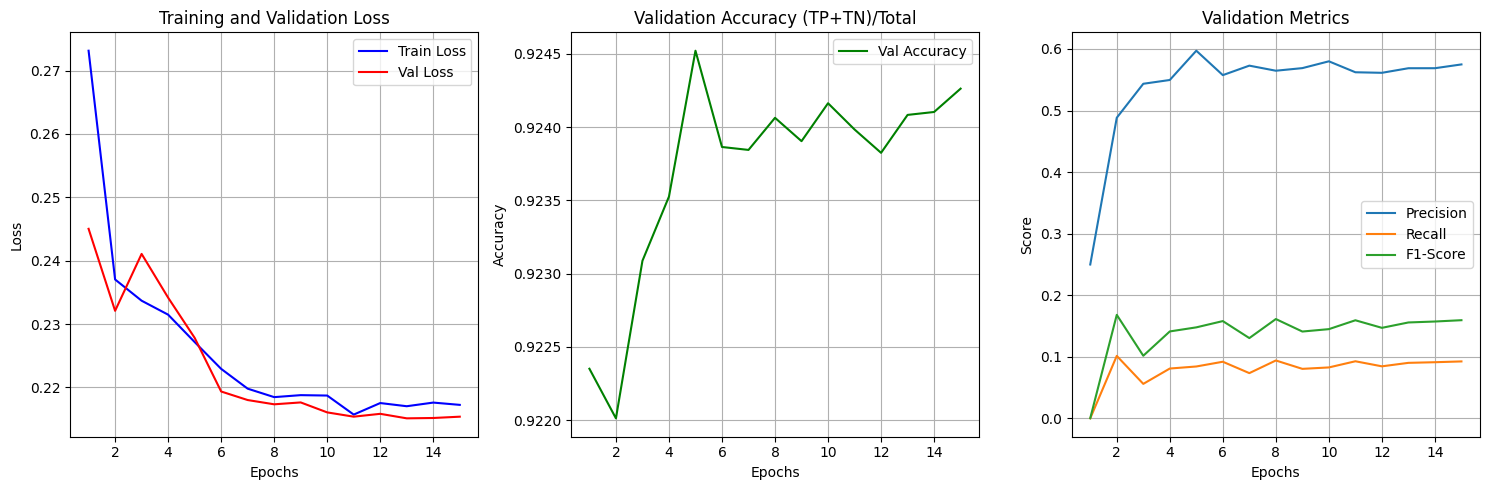

In [23]:
# Plotting Training History
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Plot Losses
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_accuracy'], 'g-', label='Val Accuracy')
    plt.title('Validation Accuracy (TP+TN)/Total')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot Precision/Recall/F1
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_precision'], label='Precision')
    plt.plot(epochs, history['val_recall'], label='Recall')
    plt.plot(epochs, history['val_f1'], label='F1-Score')
    plt.title('Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [24]:
# Detailed Evaluation on Validation Set
# (This can also be done on 'test_json' if you want final results)

# Re-use existing val_dataloader or creating test_dataloader
# eval_loader = val_dataloader 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

tp, tn, fp, fn = 0, 0, 0, 0
total_elements = 0   

print("Starting evaluation...")
with torch.no_grad():
    for images, labels in tqdm(val_dataloader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).float()
        
        # Accumulate component-wise counts
        tp += (predicted * labels).sum().item()
        tn += ((1 - predicted) * (1 - labels)).sum().item()
        fp += (predicted * (1 - labels)).sum().item()
        fn += ((1 - predicted) * labels).sum().item()
        
        total_elements += labels.numel()

epsilon = 1e-7
accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
precision = tp / (tp + fp + epsilon)
recall = tp / (tp + fn + epsilon)
f1 = 2 * (precision * recall) / (precision + recall + epsilon)

print("--- Global Metrics (Element-wise) ---")
print(f"Accuracy:  {accuracy*100:.2f}%  (TP+TN / Total)")
print(f"Precision: {precision*100:.2f}% (TP / TP+FP) - 'Of what I predict True, how much is actually true?'")
print(f"Recall:    {recall*100:.2f}%    (TP / TP+FN) - 'How much of the total do I manage to find?'")
print(f"F1-Score:  {f1*100:.2f}%")

print("\n--- Component analysis ---")
print(f"True Positives: {int(tp)}")
print(f"True Negatives: {int(tn)}")
print(f"False Positives: {int(fp)}")
print(f"False Negatives: {int(fn)}")

Starting evaluation...


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

--- Global Metrics (Element-wise) ---
Accuracy:  92.43%  (TP+TN / Total)
Precision: 57.48% (TP / TP+FP) - 'Of what I predict True, how much is actually true?'
Recall:    9.27%    (TP / TP+FN) - 'How much of the total do I manage to find?'
F1-Score:  15.96%

--- Component analysis ---
True Positives: 361
True Negatives: 46037
False Positives: 267
False Negatives: 3535


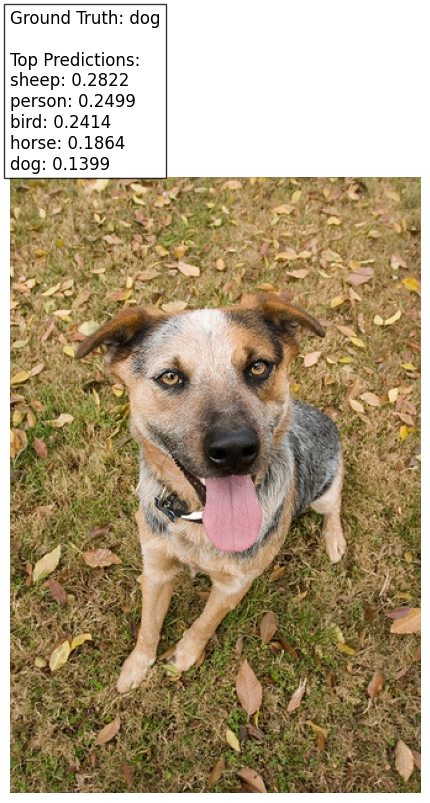

In [25]:
# Visualize an image from the validation dataset with model predictions

# Ensure val_data is available (in case previous cells were skipped)
if 'val_data' not in locals() and 'val_data' not in globals():
    with open(val_json, 'r') as f:
        val_data = json.load(f)

def visualize_image_with_predictions(image_id):
    image_info = next(img for img in val_data['images'] if img['id'] == image_id)
    fname = image_info['file_name']

    image_path = None
    for c in candidate_image_paths(fname):
        if os.path.exists(c):
            image_path = c
            break

    if image_path is None:
        raise FileNotFoundError(
            f"Image {fname} not found. Tried paths: {[str(p) for p in candidate_image_paths(fname)]}")

    image = plt.imread(image_path)
    # Preprocess image using transform_val instead of undefined transform
    input_tensor = transform_val(Image.open(image_path).convert('RGB')).unsqueeze(0)

    # Move to same device as model
    input_tensor = input_tensor.to(device)
    model.to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.sigmoid(outputs)[0] # Get probabilities for first image in batch

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    ax.axis('off')

    # Get Ground Truth
    annotations = [ann for ann in val_data['annotations'] if ann['image_id'] == image_id]
    gt_category_ids = {ann['category_id'] for ann in annotations}
    gt_names = []
    for cat_id in gt_category_ids:
         cat_info = next((cat for cat in val_data['categories'] if cat['id'] == cat_id), None)
         if cat_info:
             gt_names.append(cat_info['name'])
    
    # Get Top Predictions
    predictions = []
    for i in range(num_classes):
        # Infer category ID. Assuming 1-based index corresponding to i+1
        score = probs[i].item()
        cat_id = i + 1 
        cat_info = next((cat for cat in val_data['categories'] if cat['id'] == cat_id), None)
        name = cat_info['name'] if cat_info else f"Unknown-{cat_id}"
        predictions.append((name, score))
    
    # Sort by score desc
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Display text
    title_text = f"Ground Truth: {', '.join(gt_names)}\n\nTop Predictions:"
    for name, score in predictions[:5]:
        title_text += f"\n{name}: {score:.4f}"
        
    plt.title(title_text, loc='left', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    plt.show()

# Pick a random image if no ID is specified
import random
random_image_id = random.choice(val_data['images'])['id']
visualize_image_with_predictions(random_image_id)

In [ ]:
# Dataset per Object Detection (torchvision detection API)
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class PascalVOCDatasetDet(Dataset):
    """Restituisce (image, target) per ogni immagine.
    target: dict con chiavi 'boxes' [N,4] (xyxy), 'labels' [N], 'image_id', 'area', 'iscrowd'.
    """
    def __init__(self, data, root, transforms=None):
        self.data = data
        self.root = root
        self.transforms = transforms
        self.images = self.data['images']
        # Precalcola annotazioni per immagine
        self.by_image = {}
        for ann in self.data['annotations']:
            self.by_image.setdefault(ann['image_id'], []).append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        info = self.images[idx]
        img_id = info['id']
        fname = info['file_name']
        image_path = None
        for c in candidate_image_paths(fname):
            if os.path.exists(c):
                image_path = c
                break

        if image_path is None:
            raise FileNotFoundError(
                f"Image {fname} not found. Tried paths: {[str(p) for p in candidate_image_paths(fname)]}")

        img = Image.open(image_path).convert("RGB")
        width, height = img.size

        anns = self.by_image.get(img_id, [])
        boxes = []
        labels = []
        areas = []
        for a in anns:
            x, y, w, h = a['bbox']  # COCO-style [x, y, w, h]
            x1, y1, x2, y2 = x, y, x + w, y + h  # convert to xyxy
            # clamp nei bounds dell'immagine
            x1 = max(0, min(x1, width - 1))
            y1 = max(0, min(y1, height - 1))
            x2 = max(0, min(x2, width))
            y2 = max(0, min(y2, height))
            if x2 > x1 and y2 > y1:
                boxes.append([x1, y1, x2, y2])
                labels.append(a['category_id'])  # 1..num_classes (0 = sfondo)
                areas.append((x2 - x1) * (y2 - y1))

        import torchvision.transforms as T
        if self.transforms is not None:
            img = self.transforms(img)
        else:
            img = T.ToTensor()(img)  # niente resize per non rompere i box

        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([img_id]),
            'area': torch.as_tensor(areas, dtype=torch.float32),
            'iscrowd': torch.zeros((len(labels),), dtype=torch.int64)
        }
        return img, target


def det_collate_fn(batch):
    # batch: list of (image, target)
    return tuple(zip(*batch))

In [36]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 20 + 1  # 20 classi + background
weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
model_det = fasterrcnn_resnet50_fpn(weights=weights)  # backbone+RPN+ROI heads preaddestrati

# Sostituisci la testa di classificazione/regressione box per le tue classi
in_features = model_det.roi_heads.box_predictor.cls_score.in_features
model_det.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model_det.train()  # poi avvii il training sul tuo DataLoader detection

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Dataset, DataLoader e optimizer per Object Detection (congelando backbone+RPN)
import torch
from torch.utils.data import DataLoader

# Dataset/train loader (VOC detection)
train_det_dataset = PascalVOCDatasetDet(train_data, dataset_root, transforms=None)
train_det_loader = DataLoader(
    train_det_dataset,
    batch_size=4,           # batch piccolo per RAM/CPU
    shuffle=True,
    num_workers=0,          # su Windows spesso 0 è più stabile
    collate_fn=det_collate_fn
)

# Device handling
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_det.to(device)

# Congela backbone e RPN (i pesi COCO restano fissi)
for p in model_det.backbone.parameters():
    p.requires_grad = False
for p in model_det.rpn.parameters():
    p.requires_grad = False

# Parametri allenabili: solo ROI heads box_head + box_predictor
trainable_params = []
for p in model_det.roi_heads.box_head.parameters():
    p.requires_grad = True
    trainable_params.append(p)
for p in model_det.roi_heads.box_predictor.parameters():
    p.requires_grad = True
    trainable_params.append(p)

# Optimizer solo per i parametri trainabili
optimizer_det = torch.optim.SGD(trainable_params, lr=0.01, momentum=0.9, weight_decay=0.0005)

In [38]:
# Training/Caricamento per Object Detection (Faster R-CNN) con backbone+RPN congelati
from tqdm.notebook import tqdm
import torch, os

model_det_path = "fasterrcnn_voc.pth"

if os.path.exists(model_det_path):
    # Carica e usa direttamente senza retraining
    state = torch.load(model_det_path, map_location=device)
    model_det.load_state_dict(state)
    model_det.eval()
    print(f"Modello detection caricato da: {model_det_path}. Training saltato.")
else:
    print("Nessun modello detection salvato trovato. Avvio training e salvataggio...")
    num_epochs_det = 1
    for epoch in range(num_epochs_det):
        model_det.train()
        running = 0.0
        for images, targets in tqdm(train_det_loader, desc=f"Det Epoch {epoch+1}/{num_epochs_det}"):
            # sposta batch su device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model_det(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer_det.zero_grad()
            losses.backward()
            optimizer_det.step()

            running += losses.item()
        print(f"[DET] Epoch {epoch+1}/{num_epochs_det} - Loss: {running/max(1, len(train_det_loader)):.4f}")

    # Salvataggio modello detection
    torch.save(model_det.state_dict(), model_det_path)
    print("Modello detection salvato:", model_det_path)
    model_det.eval()

Nessun modello detection salvato trovato. Avvio training e salvataggio...


Det Epoch 1/1:   0%|          | 0/626 [00:00<?, ?it/s]

[DET] Epoch 1/1 - Loss: 0.4058
Modello detection salvato: fasterrcnn_voc.pth


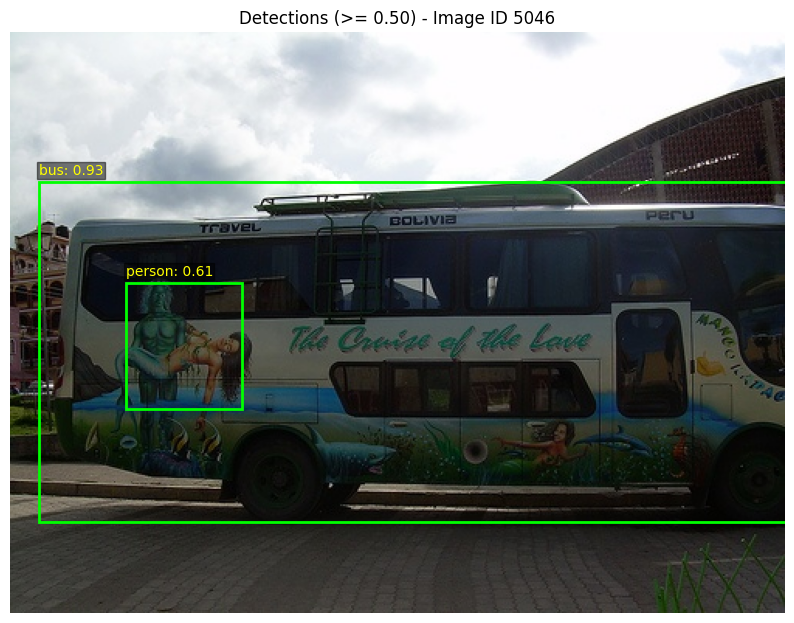

In [54]:
# [FONDO] Visualizzazione detection (ridefinita qui per rimanere in fondo)
import os, random
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T
from PIL import Image

# mappa id->name per labels (1..num_classes) da VOC
id_to_name = {cat['id']: cat['name'] for cat in train_data['categories']}

def visualize_detections(image_id=None, ds=None, score_thresh=0.5, max_dets=50):
    if ds is None:
        raise ValueError("please specify dataset as 'ds' parameter")

    imgs = ds['images']

    if image_id is None:
        image_id = random.choice(imgs)['id']

    info = next(img for img in imgs if img['id'] == image_id)
    fname = info['file_name']

    image_path = None
    for c in candidate_image_paths(fname):
        if os.path.exists(c):
            image_path = c
            break

    if image_path is None:
        raise FileNotFoundError(
            f"Image {fname} not found. Tried paths: {[str(p) for p in candidate_image_paths(fname)]}")

    # carica immagine (no resize per detection)
    pil_img = Image.open(image_path).convert('RGB')
    img_tensor = T.ToTensor()(pil_img)

    model_det.eval()
    with torch.no_grad():
        outputs = model_det([img_tensor.to(device)])[0]

    boxes = outputs.get('boxes', torch.empty((0, 4)))
    labels = outputs.get('labels', torch.empty((0,), dtype=torch.long))
    scores = outputs.get('scores', torch.empty((0,)))

    # filtra per soglia
    keep = (scores >= score_thresh).nonzero(as_tuple=False).squeeze(1)
    boxes = boxes[keep][:max_dets].cpu()
    labels = labels[keep][:max_dets].cpu()
    scores = scores[keep][:max_dets].cpu()

    # plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(pil_img)
    for b, lab, sc in zip(boxes, labels, scores):
        x1, y1, x2, y2 = b.tolist()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        name = id_to_name.get(int(lab), str(int(lab)))
        ax.text(x1, max(0, y1 - 5), f"{name}: {float(sc):.2f}", color='yellow', fontsize=10, bbox=dict(facecolor='black', alpha=0.5, pad=1))
    ax.set_title(f"Detections (>= {score_thresh:.2f}) - Image ID {image_id}")
    ax.axis('off')
    plt.show()

# Esempio d'uso:
visualize_detections(ds=eval_data, score_thresh=0.5)

In [56]:
# [FONDO] Valutazione detection su set di test (VOC2007 mAP@0.5)
import torch, os, json
from torch.utils.data import DataLoader
import torchvision.transforms as T
from typing import List, Dict, Tuple
            
# Dataset/Loader per eval (no resize)
eval_det_dataset = PascalVOCDatasetDet(eval_data, dataset_root, transforms=None)
eval_det_loader = DataLoader(
    eval_det_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=det_collate_fn
)

# Utility IoU
def box_iou_xyxy(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    # a: [Na,4], b: [Nb,4]
    if a.numel() == 0 or b.numel() == 0:
        return a.new_zeros((a.shape[0], b.shape[0]))
    x11, y11, x12, y12 = a[:,0], a[:,1], a[:,2], a[:,3]
    x21, y21, x22, y22 = b[:,0], b[:,1], b[:,2], b[:,3]
    xi1 = torch.max(x11[:, None], x21[None, :])
    yi1 = torch.max(y11[:, None], y21[None, :])
    xi2 = torch.min(x12[:, None], x22[None, :])
    yi2 = torch.min(y12[:, None], y22[None, :])
    inter = (xi2 - xi1).clamp(min=0) * (yi2 - yi1).clamp(min=0)
    area_a = (x12 - x11).clamp(min=0) * (y12 - y11).clamp(min=0)
    area_b = (x22 - x21).clamp(min=0) * (y22 - y21).clamp(min=0)
    union = area_a[:, None] + area_b[None, :] - inter
    return inter / (union + 1e-8)

# Calcolo AP stile VOC2007 (11-point)
def voc07_ap(rec: List[float], prec: List[float]) -> float:
    ap = 0.0
    for t in [i/10 for i in range(0, 11)]:
        # migliore precisione a recall >= t
        pmax = 0.0
        for r, pr in zip(rec, prec):
            if r >= t:
                pmax = max(pmax, pr)
        ap += pmax / 11.0
    return ap

@torch.no_grad()
def evaluate_map(iou_thr: float = 0.5, limit: int = None) -> Tuple[float, Dict[int, float]]:
    model_det.eval()
    # Colleziona predizioni globali per classe: {cls: [(score, img_idx, box), ...]}
    preds: Dict[int, List[Tuple[float, int, torch.Tensor]]] = {}
    # Conteggio GT per classe
    npos: Dict[int, int] = {}

    # Precarica GT per tutte le immagini
    gt_all = []
    for img_idx in range(len(eval_det_dataset)):
        _, t = eval_det_dataset[img_idx]
        gt_all.append(t)
        for lab in t['labels'].tolist():
            npos[lab] = npos.get(lab, 0) + 1

    for img_idx, (images, targets) in enumerate(eval_det_loader):
        if limit is not None and img_idx >= limit:
            break
        images = [images[0].to(device)]
        outputs = model_det(images)[0]

        boxes = outputs.get('boxes', torch.empty((0, 4), device=device))
        labels = outputs.get('labels', torch.empty((0,), dtype=torch.long, device=device))
        scores = outputs.get('scores', torch.empty((0,), device=device))
        for b, l, s in zip(boxes, labels, scores):
            preds.setdefault(int(l), []).append((float(s), img_idx, b.detach().cpu()))

    # Calcolo AP per classe
    ap_per_class: Dict[int, float] = {}
    for cls, dets in preds.items():
        dets.sort(key=lambda x: x[0], reverse=True)
        tp = []
        fp = []
        matched: Dict[int, List[int]] = {}
        # inizializza matched per ogni immagine per questa classe
        for img_idx in range(min(len(eval_det_dataset), limit if limit is not None else len(eval_det_dataset))):
            t = gt_all[img_idx]
            m = (t['labels'] == cls)
            matched[img_idx] = [0] * int(m.sum().item())

        for score, img_idx, box in dets:
            t = gt_all[img_idx]
            m = (t['labels'] == cls)
            gt_boxes_cls = t['boxes'][m]
            if gt_boxes_cls.numel() == 0:
                fp.append(1)
                tp.append(0)
                continue
            ious = box_iou_xyxy(box.unsqueeze(0), gt_boxes_cls).squeeze(0)
            best_iou, best_j = (ious.max().item(), int(ious.argmax().item())) if ious.numel() > 0 else (0.0, -1)
            if best_iou >= iou_thr and matched[img_idx][best_j] == 0:
                tp.append(1)
                fp.append(0)
                matched[img_idx][best_j] = 1
            else:
                tp.append(0)
                fp.append(1)
        if not tp:
            ap_per_class[cls] = 0.0
            continue
        tp_cum = torch.tensor(tp).cumsum(0).float()
        fp_cum = torch.tensor(fp).cumsum(0).float()
        npos_cls = npos.get(cls, 0)
        if npos_cls == 0:
            ap_per_class[cls] = 0.0
            continue
        rec = (tp_cum / npos_cls).tolist()
        prec = (tp_cum / (tp_cum + fp_cum + 1e-8)).tolist()
        ap_per_class[cls] = voc07_ap(rec, prec)

    valid_ids = [cat['id'] for cat in train_data['categories']]
    valid = [ap_per_class[c] for c in ap_per_class.keys() if c in valid_ids]
    mAP = sum(valid) / max(1, len(valid)) if valid else 0.0
    return mAP, ap_per_class

# Esegui valutazione (imposta limit per velocizzare le prove, es. 200)
mAP, ap_cls = evaluate_map(iou_thr=0.5, limit=None)
print(f"mAP@0.5 (VOC07): {mAP:.4f}")
name_by_id = {cat['id']: cat['name'] for cat in train_data['categories']}
for cid in sorted(ap_cls.keys()):
    if cid in name_by_id:
        print(f"  {cid:2d} {name_by_id[cid]:12s}: AP={ap_cls[cid]:.4f}")

mAP@0.5 (VOC07): 0.7342
   1 aeroplane   : AP=0.8093
   2 bicycle     : AP=0.7958
   3 bird        : AP=0.6925
   4 boat        : AP=0.6100
   5 bottle      : AP=0.6669
   6 bus         : AP=0.8024
   7 car         : AP=0.8518
   8 cat         : AP=0.8178
   9 chair       : AP=0.5840
  10 cow         : AP=0.8054
  11 diningtable : AP=0.5753
  12 dog         : AP=0.6738
  13 horse       : AP=0.8089
  14 motorbike   : AP=0.8219
  15 person      : AP=0.8496
  16 pottedplant : AP=0.5425
  17 sheep       : AP=0.7732
  18 sofa        : AP=0.6466
  19 train       : AP=0.7811
  20 tvmonitor   : AP=0.7755
